In [17]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path
from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from cluster_half_shelfs_alpha import Half_shelf_cluster
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.stats import norm
from cluster_to_edge_pixel import contour_edge
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
from cake import cake
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from scipy import signal
from scipy.spatial.transform import Rotation as R
from cluster_half_shelfs_alpha import Half_shelf_cluster
from cluster_to_edge_pixel import contour_edge
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib.patches import Arc
from confectionery import Confectionery
from utitlity_functions import *
from scipy.spatial.transform import Rotation as R
import matplotlib as mpl
from matplotlib import cm
from particle_data_structure import ParticleDataStruct
import os
import matplotlib
from matplotlib.patches import Patch

import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 11,
    'text.usetex': True,
})
import matplotlib.patches as mpatches
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal


np.random.seed(137)

In [18]:
folder_name="Gute_aufnahme_shortened"

data_paths=os.listdir(os.path.join("../data",folder_name))
stream_string=np.load(os.path.join("../data",folder_name,"image_paths_smooth.npy"))
objs=[x for x in data_paths if "pos_data" in x]
objs_number=np.array([int(x[9:-4]) for x in objs])
indexing=np.argsort(objs_number)
objs=[np.load(os.path.join("../data",folder_name,objs[x])) for x in indexing]
number_objs=len(objs)
koppenrath=Confectionery()


In [19]:
cut_radius=[int(np.floor(np.mean(x[:,-1])))-1 for x in objs]
rotation_vector_trajectories=[np.load("../data/Gute_aufnahme_shortened/rotation_trajectory_as_rotvec_"+str(i)+".npy") for i in range(15)]


In [20]:
X_true=[x[:,1] for x in objs]
Y_true=[x[:,2] for x in objs]
dX=[np.diff(x) for x in X_true]
dY=[np.diff(x) for x in Y_true]
L=[np.add.accumulate(np.sqrt(x**2+y**2)) for x,y in zip(dX,dY)]
L_pos=[np.append(np.zeros(1),x) for x in L]
pos_from_estimation=[x[:,1:3] for x in objs]


In [69]:
pos_from_rot=[]
L_rot=[]
for i in range(number_objs):
    v1_flat=np.copy((rotation_vector_trajectories[i])[:,[1,0]])
    v1_flat[:,1]=-v1_flat[:,1]
    normalization_factor=[np.linalg.norm(x) for x in v1_flat]
    normalization_factor=np.array([x if x>1e-6 else 1 for x in normalization_factor])
    v1_flat=v1_flat/normalization_factor[:,np.newaxis]

    r=np.mean(objs[i][:,-1])
    p_0=np.array([0,0,1])

    rotation_trajectory_dict=dict([[j,R.from_rotvec(r)] for j,r in enumerate(rotation_vector_trajectories[i])])
    dist=distance_rot_on_sphere(p_0,rotation_trajectory_dict,r)
    L_rot.append(np.copy(dist))
    dist=dist[1:]-dist[:-1]

    V1=dist[:,np.newaxis]*v1_flat
    V1=np.concatenate((np.array([objs[i][0,1],objs[i][0,2]]).reshape((1,2)),V1),axis=0)
    pos_from_rot.append(np.add.accumulate(V1))

In [22]:
pos_from_rot[0][:3,:]
pos_from_estimation[0][:3,:]

array([[ 879.5, 1242.5],
       [ 879.5, 1241.5],
       [ 880.5, 1240.5]])

# plot error of object 11

In [23]:
rotation_vector_trajectories[11].shape

(100, 3)

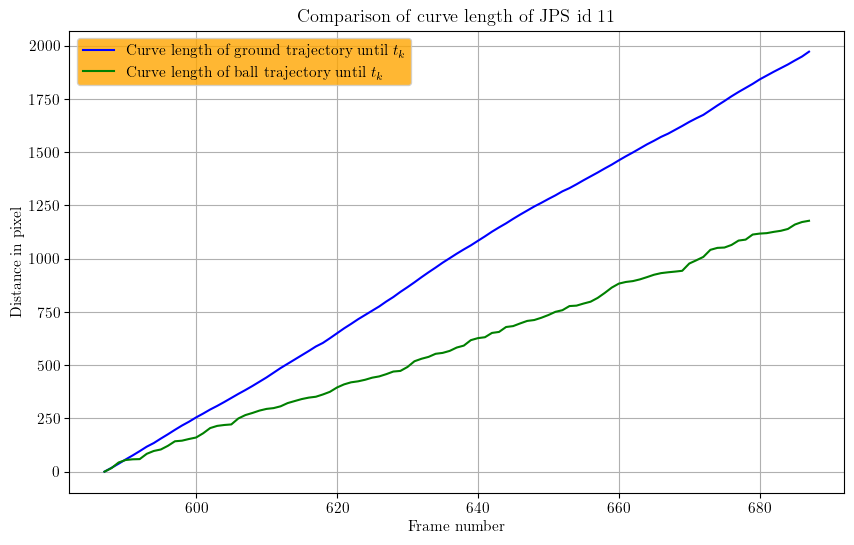

In [24]:
t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,L_pos[11],color="blue",label="Curve length of ground trajectory until $t_k$")
ax.plot(t,L_rot[11],color="green",label="Curve length of ball trajectory until $t_k$")
plt.title('Comparison of curve length of JPS id 11')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/distance_comparison.eps', format="eps", dpi=1200, bbox_inches="tight")

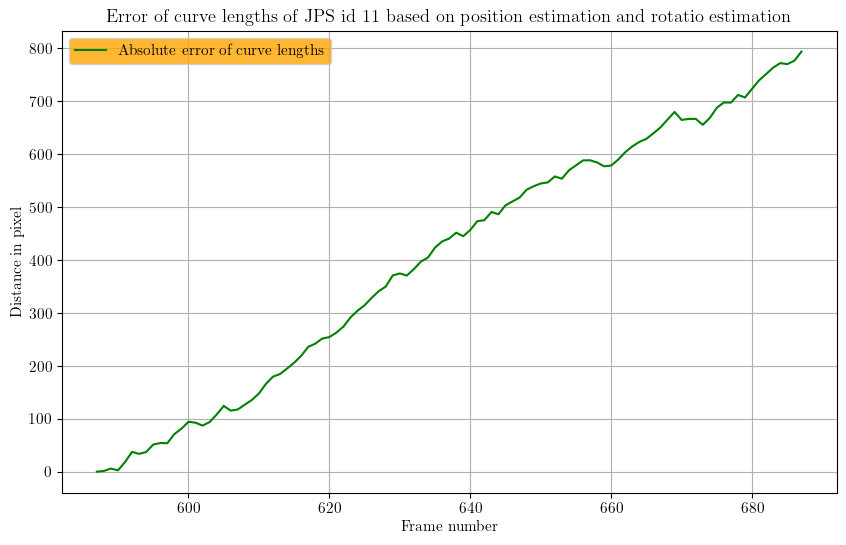

In [25]:


t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.abs(L_rot[11]-L_pos[11]),color="green",label="Absolute error of curve lengths")
plt.title('Error of curve lengths of JPS id 11 based on position estimation and rotatio estimation')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')


# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/error_length_11.eps', format="eps", dpi=1200, bbox_inches="tight")

In [70]:
e=np.abs(L_rot[11]-L_pos[11])
a=np.arange(e.size).reshape((-1,1))
m_error=np.linalg.pinv(a)@e[:,np.newaxis]
m1=np.linalg.pinv(a)@L_pos[11][:,np.newaxis]
m2=np.linalg.pinv(a)@L_rot[11][:,np.newaxis]

In [94]:
m_error

array([[8.097]])

In [78]:
m1=np.linalg.pinv(a)@L_pos[11][:,np.newaxis]
m2=np.linalg.pinv(a)@L_rot[11][:,np.newaxis]

In [101]:
m2

array([[11.842]])

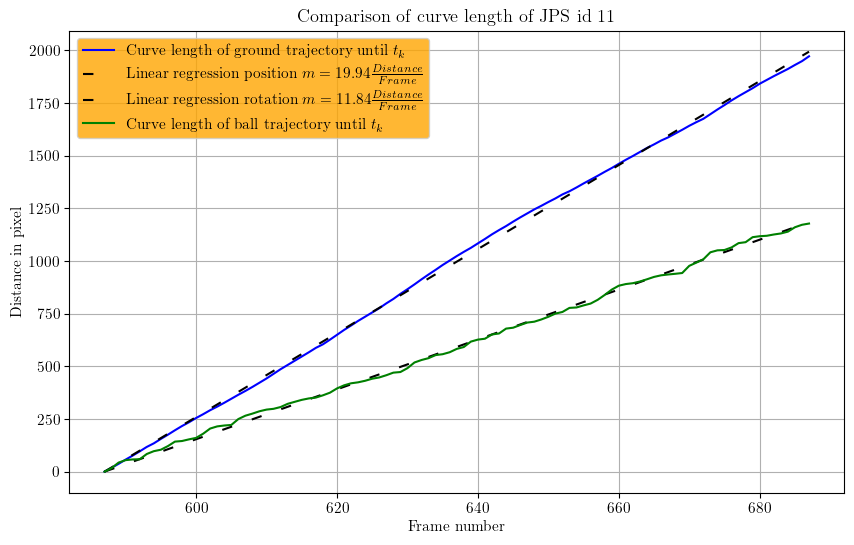

In [106]:
t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,L_pos[11],color="blue",label="Curve length of ground trajectory until $t_k$")
ax.plot(t,m1*a,color="black",label=r'Linear regression position $m=19.94\frac{Distance}{Frame}$',linestyle=(0, (5, 10)))
ax.plot(t,m2*a,color="black",label=r'Linear regression rotation $m=11.84\frac{Distance}{Frame}$',linestyle=(0, (5, 10)))
ax.plot(t,L_rot[11],color="green",label="Curve length of ball trajectory until $t_k$")
plt.title('Comparison of curve length of JPS id 11')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)


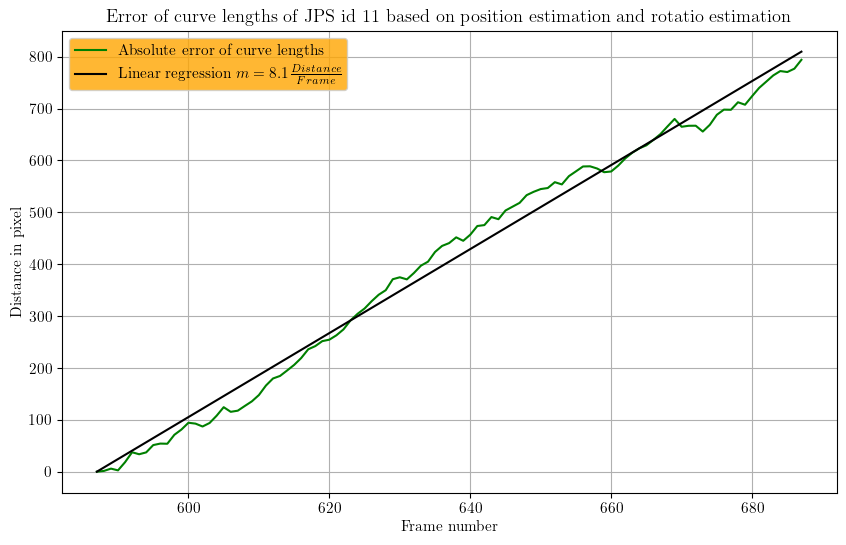

In [95]:


t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.abs(L_rot[11]-L_pos[11]),color="green",label="Absolute error of curve lengths")
ax.plot(t,m_error*a,color="black",label=r'Linear regression $m=8.1\frac{Distance}{Frame}$')

plt.title('Error of curve lengths of JPS id 11 based on position estimation and rotatio estimation')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')


# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)


array([[8.097]])

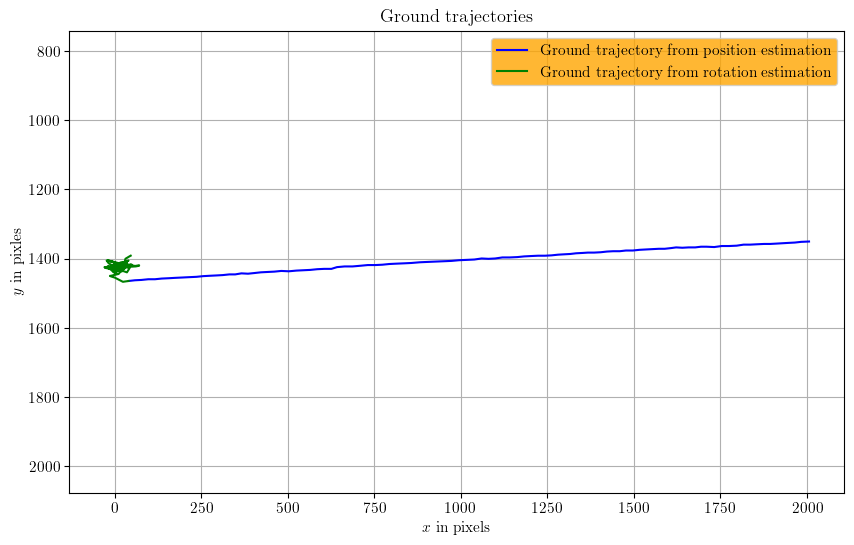

In [29]:

fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(pos_from_estimation[11][:,0],pos_from_estimation[11][:,1],color="blue",label="Ground trajectory from position estimation")
ax.plot(pos_from_rot[11][:,0],pos_from_rot[11][:,1],color="green",label="Ground trajectory from rotation estimation")
plt.title('Ground trajectories')
plt.xlabel('$x$ in pixels')
plt.ylabel('$y$ in pixles')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
ax.set_rasterized(True)
ax.axis("equal")
ax.invert_yaxis()
plt.show()

fig.savefig('../export_graphs/ground_trajectories_11.eps', format="eps", dpi=1200, bbox_inches="tight")

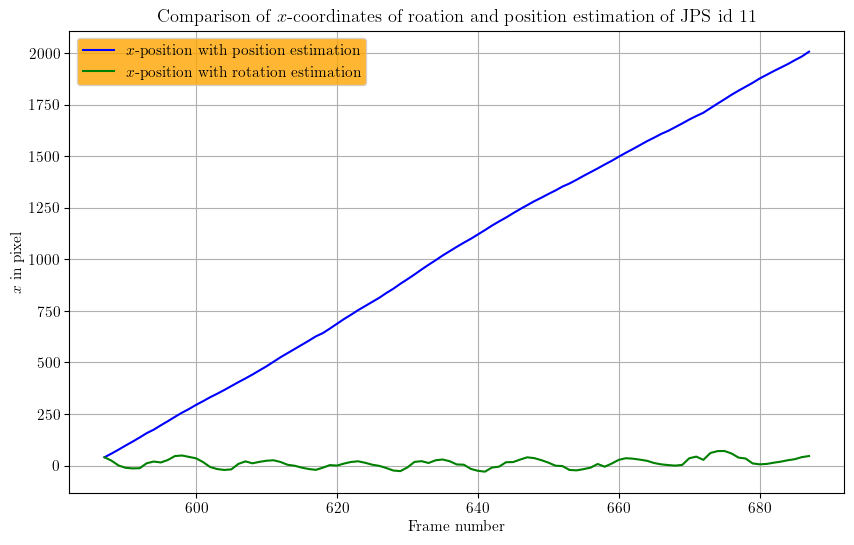

In [30]:


t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,pos_from_estimation[11][:,0],color="blue",label="$x$-position with position estimation")
ax.plot(t,pos_from_rot[11][:,0],color="green",label="$x$-position with rotation estimation")
plt.title('Comparison of $x$-coordinates of roation and position estimation of JPS id 11')
plt.xlabel('Frame number')
plt.ylabel('$x$ in pixel')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/x_pos_11.eps', format="eps", dpi=1200, bbox_inches="tight")

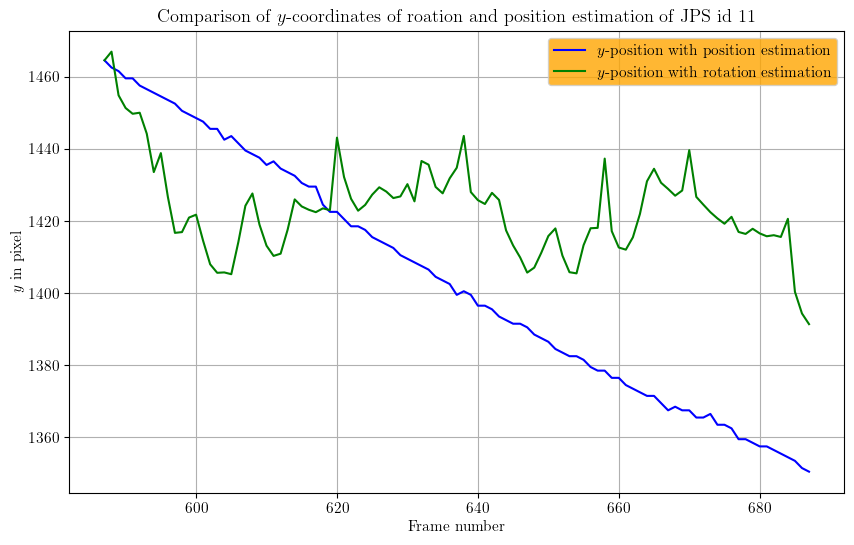

In [31]:


t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,pos_from_estimation[11][:,1],color="blue",label="$y$-position with position estimation")
ax.plot(t,pos_from_rot[11][:,1],color="green",label="$y$-position with rotation estimation")
plt.title('Comparison of $y$-coordinates of roation and position estimation of JPS id 11')
plt.xlabel('Frame number')
plt.ylabel('$y$ in pixel')


# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/y_pos_11.eps', format="eps", dpi=1200, bbox_inches="tight")

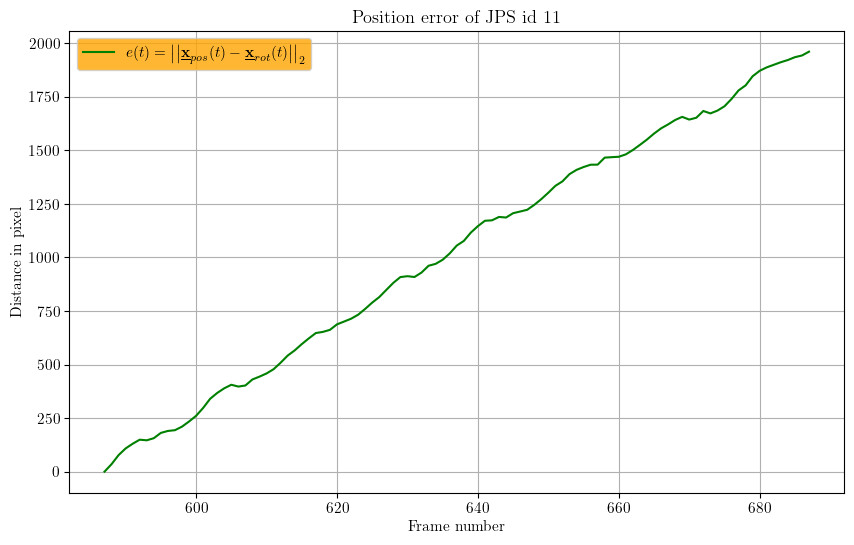

In [32]:


t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.linalg.norm(pos_from_estimation[11]-pos_from_rot[11],axis=1),color="green",label=r'$e(t)= \left|\left|\underline{\mathbf{x}}_{pos}(t)-\underline{\mathbf{x}}_{rot}(t)\right|\right|_2$')
plt.title('Position error of JPS id 11')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')

# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/error_11.eps', format="eps", dpi=1200, bbox_inches="tight")

In [110]:
m

array([[20.246]])

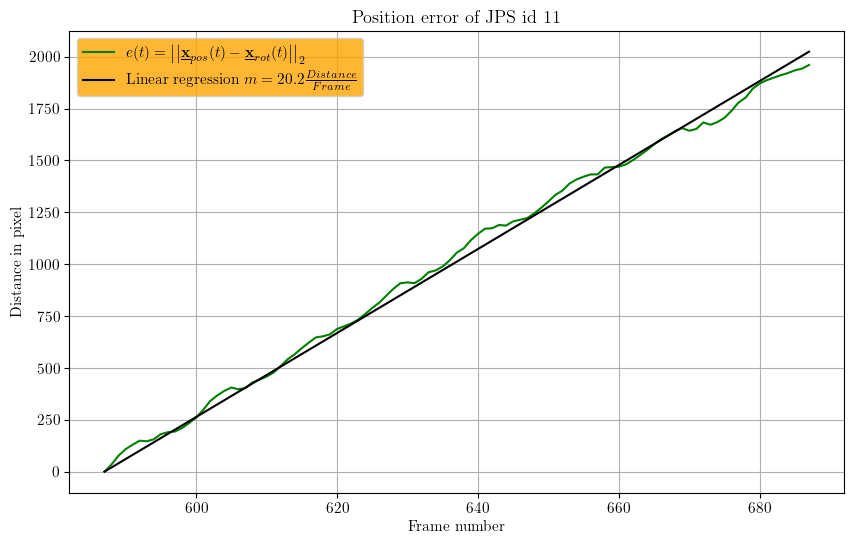

In [112]:
m=np.linalg.pinv(a)@np.linalg.norm(pos_from_estimation[11]-pos_from_rot[11],axis=1).reshape((-1,1))


t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.linalg.norm(pos_from_estimation[11]-pos_from_rot[11],axis=1),color="green",label=r'$e(t)= \left|\left|\underline{\mathbf{x}}_{pos}(t)-\underline{\mathbf{x}}_{rot}(t)\right|\right|_2$')
ax.plot(t,m*a,color="black",label=r'Linear regression $m=20.2\frac{Distance}{Frame}$')

plt.title('Position error of JPS id 11')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')

# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)


# trajectory only to the right

In [33]:
pos_from_rot_right=[]
L_rot=[]
for i in range(number_objs):
    v1_flat=np.copy((rotation_vector_trajectories[i])[:,[1,0]])
    v1_flat[:,1]=-v1_flat[:,1]
    normalization_factor=[np.linalg.norm(x) for x in v1_flat]
    normalization_factor=np.array([x if x>1e-6 else 1 for x in normalization_factor])
    v1_flat=v1_flat/normalization_factor[:,np.newaxis]

    r=np.mean(objs[i][:,-1])
    p_0=np.array([0,0,1])

    rotation_trajectory_dict=dict([[j,R.from_rotvec(r)] for j,r in enumerate(rotation_vector_trajectories[i])])
    dist=distance_rot_on_sphere(p_0,rotation_trajectory_dict,r)
    L_rot.append(np.copy(dist))
    dist=dist[1:]-dist[:-1]

    V1=dist[:,np.newaxis]*v1_flat
    index_left=V1[:,0]<0
    V1[index_left,:]=-V1[index_left,:]
    V1=np.concatenate((np.array([objs[i][0,1],objs[i][0,2]]).reshape((1,2)),V1),axis=0)

    pos_from_rot_right.append(np.add.accumulate(V1))

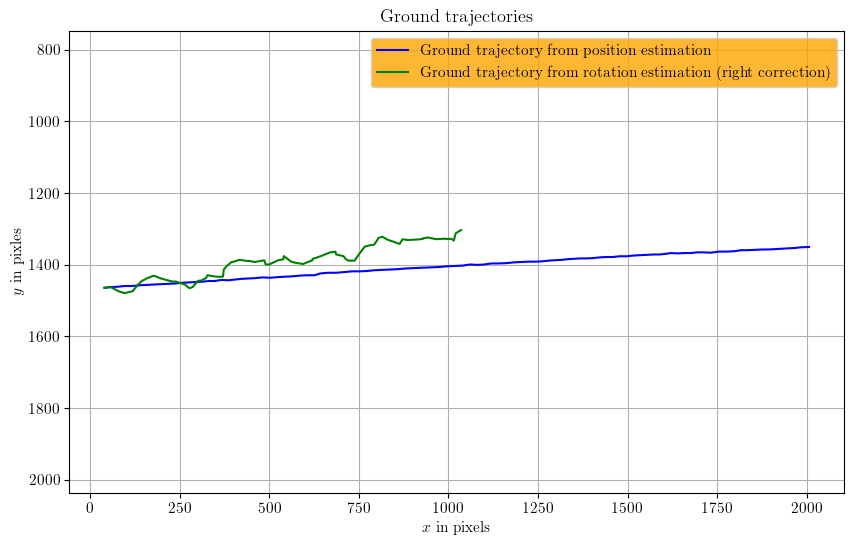

In [34]:


fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(pos_from_estimation[11][:,0],pos_from_estimation[11][:,1],color="blue",label="Ground trajectory from position estimation")
ax.plot(pos_from_rot_right[11][:,0],pos_from_rot_right[11][:,1],color="green",label="Ground trajectory from rotation estimation (right correction)")
plt.title('Ground trajectories')
plt.xlabel('$x$ in pixels')
plt.ylabel('$y$ in pixles')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
ax.set_rasterized(True)
ax.axis("equal")
ax.invert_yaxis()
plt.show()

fig.savefig('../export_graphs/right_ground_trajectories_11.eps', format="eps", dpi=1200, bbox_inches="tight")

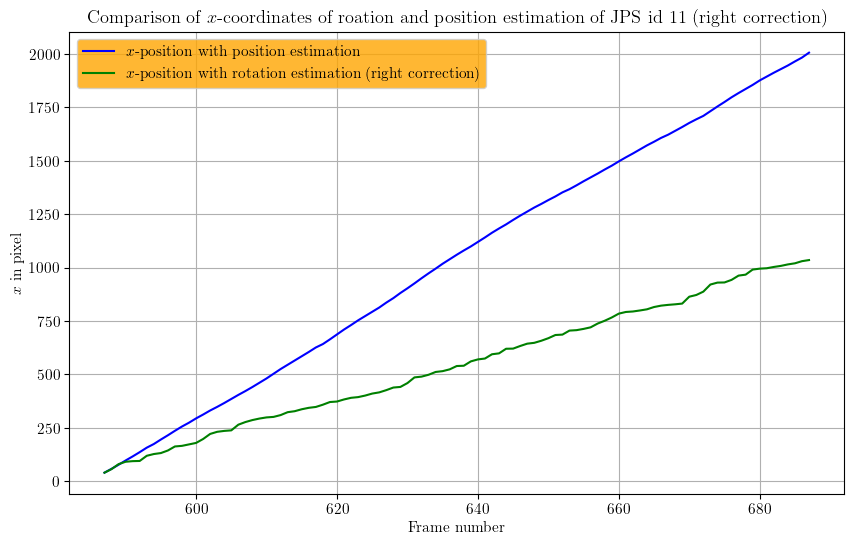

In [35]:

t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,pos_from_estimation[11][:,0],color="blue",label="$x$-position with position estimation")
ax.plot(t,pos_from_rot_right[11][:,0],color="green",label="$x$-position with rotation estimation (right correction)")
plt.title('Comparison of $x$-coordinates of roation and position estimation of JPS id 11 (right correction)')
plt.xlabel('Frame number')
plt.ylabel('$x$ in pixel')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/right_x_pos_11.eps', format="eps", dpi=1200, bbox_inches="tight")

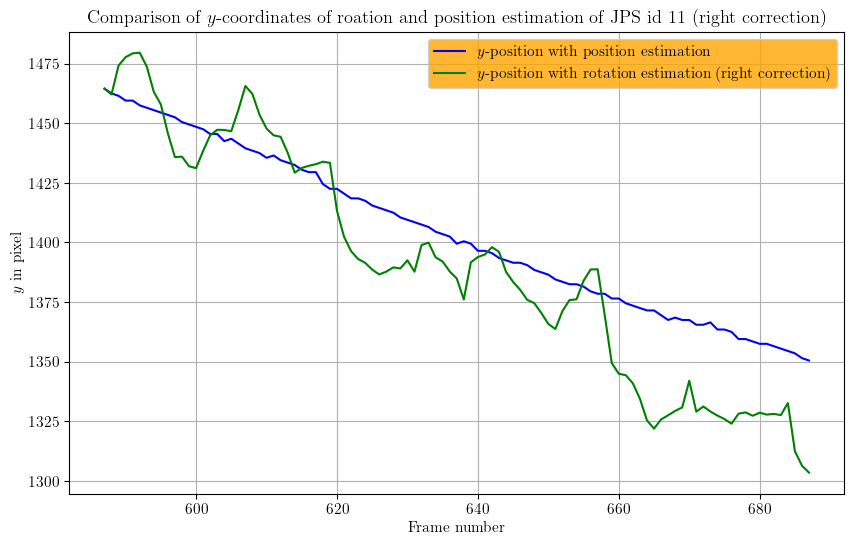

In [36]:
t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,pos_from_estimation[11][:,1],color="blue",label="$y$-position with position estimation")
ax.plot(t,pos_from_rot_right[11][:,1],color="green",label="$y$-position with rotation estimation (right correction)")
plt.title('Comparison of $y$-coordinates of roation and position estimation of JPS id 11 (right correction)')
plt.xlabel('Frame number')
plt.ylabel('$y$ in pixel')


# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/right_y_pos_11.eps', format="eps", dpi=1200, bbox_inches="tight")

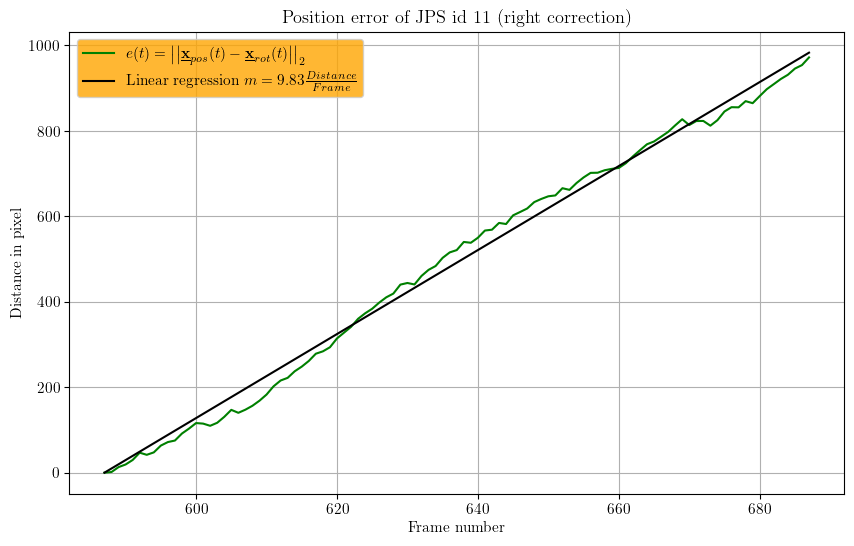

In [116]:
m=np.linalg.pinv(a)@np.linalg.norm(pos_from_estimation[11]-pos_from_rot_right[11],axis=1).reshape((-1,1))

t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.linalg.norm(pos_from_estimation[11]-pos_from_rot_right[11],axis=1),color="green",label=r'$e(t)= \left|\left|\underline{\mathbf{x}}_{pos}(t)-\underline{\mathbf{x}}_{rot}(t)\right|\right|_2$')
ax.plot(t,m*a,color="black",label=r'Linear regression $m=9.83\frac{Distance}{Frame}$')

plt.title('Position error of JPS id 11 (right correction)')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')

# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
#fig.savefig('../export_graphs/right_error_11.eps', format="eps", dpi=1200, bbox_inches="tight")

In [16]:
e=np.linalg.norm(pos_from_estimation[11]-pos_from_rot_right[11],axis=1)
a=np.arange(e.size).reshape((-1,1))
m_error=np.linalg.pinv(a)@e[:,np.newaxis]

NameError: name 'pos_from_rot_right' is not defined

In [ ]:
t=np.arange(L_pos[11].size)+int(objs[11][0,0])
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.linalg.norm(pos_from_estimation[11]-pos_from_rot_right[11],axis=1),color="green",label=r'$e(t)= \left|\left|\underline{\mathbf{x}}_{pos}(t)-\underline{\mathbf{x}}_{rot}(t)\right|\right|_2$')
plt.title('Position error of JPS id 11 (right correction)')
plt.xlabel('Frame number')
plt.ylabel('Distance in pixel')
ax.plot(t,a*m_error,color="black",label="Linear Regression")

# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/right_error_11_regression.eps', format="eps", dpi=1200, bbox_inches="tight")

# average values

In [19]:
Ntrack=[]
for i in range(15):
    Ntrack.append(L_pos[i].shape[0])
Ntrack=np.array(Ntrack)


In [20]:
Ntrack

array([100, 133,  94,  93,  30,  32,  99,  61,  30,  25,  49, 101,  90,
        79,  68])

In [21]:
t_max=61

In [23]:
L_pos_avg=np.zeros((t_max,))
L_rot_avg=np.zeros((t_max,))
for j in range(t_max):
    L_pos_avg[j]=np.array([L_pos[i][j] for i in np.arange(15)[Ntrack>j]]).mean()
    L_rot_avg[j]=np.array([L_rot[i][j] for i in np.arange(15)[Ntrack>j]]).mean()

pos_from_estimation_avg=np.zeros((t_max,2))
pos_from_rotation_avg=np.zeros((t_max,2))
pos_from_rotation_right_avg=np.zeros((t_max,2))

for j in range(t_max):
    pos_from_estimation_avg[j]=np.mean(np.array([pos_from_estimation[i][j,:] for i in np.arange(15)[Ntrack>j]]),axis=0)
    pos_from_rotation_right_avg[j]=np.mean(np.array([pos_from_rot_right[i][j] for i in np.arange(15)[Ntrack>j]]),axis=0)
    pos_from_rotation_avg[j]=np.mean(np.array([pos_from_rot[i][j] for i in np.arange(15)[Ntrack>j]]),axis=0)

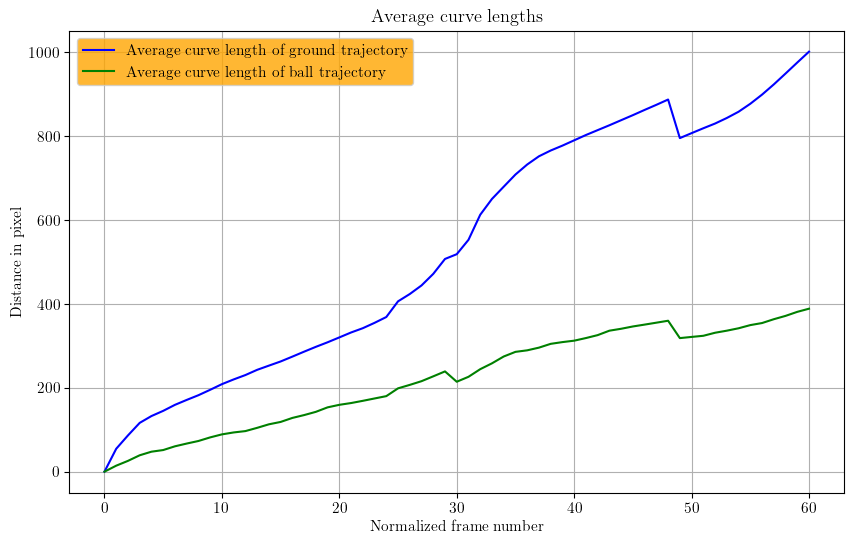

In [24]:


t=np.arange(t_max)
fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,L_pos_avg,color="blue",label="Average curve length of ground trajectory")
ax.plot(t,L_rot_avg,color="green",label="Average curve length of ball trajectory")
plt.title('Average curve lengths')
plt.xlabel('Normalized frame number')
plt.ylabel('Distance in pixel')




# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/avg_distance_comparison.eps', format="eps", dpi=1200, bbox_inches="tight")

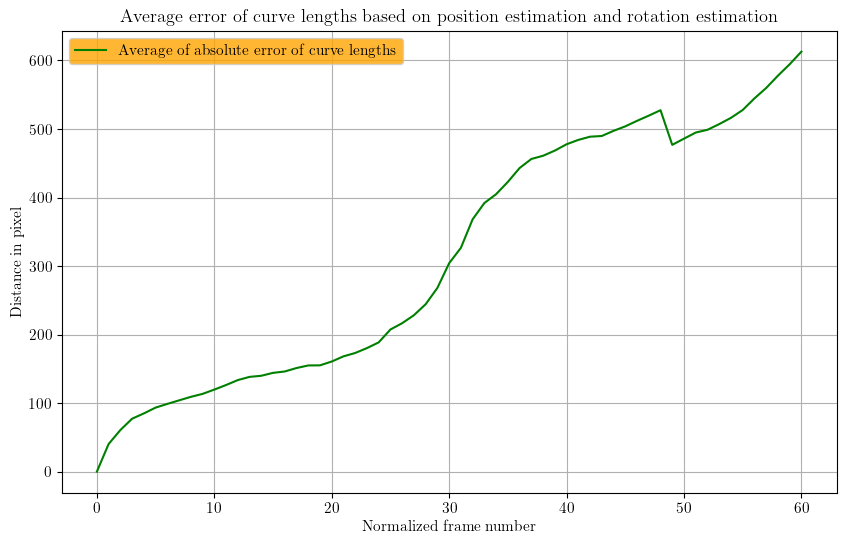

In [25]:


fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.abs(L_pos_avg-L_rot_avg),color="green",label="Average of absolute error of curve lengths")
plt.title('Average error of curve lengths based on position estimation and rotation estimation')
plt.xlabel('Normalized frame number')
plt.ylabel('Distance in pixel')


# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/avg_error_length.eps', format="eps", dpi=1200, bbox_inches="tight")

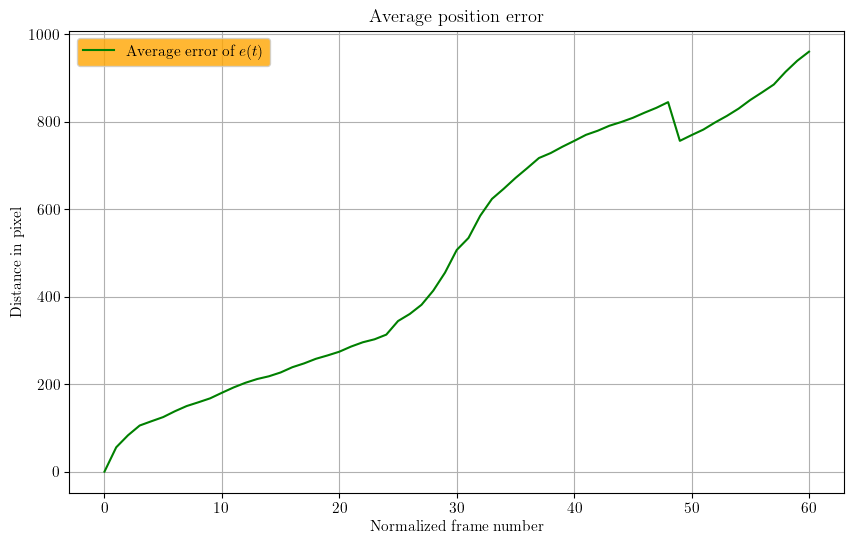

In [28]:

fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.linalg.norm(pos_from_estimation_avg-pos_from_rotation_avg,axis=1),color="green",label="Average error of $e(t)$")
plt.title('Average position error')
plt.xlabel('Normalized frame number')
plt.ylabel('Distance in pixel')

# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/avg_error_pos.eps', format="eps", dpi=1200, bbox_inches="tight")

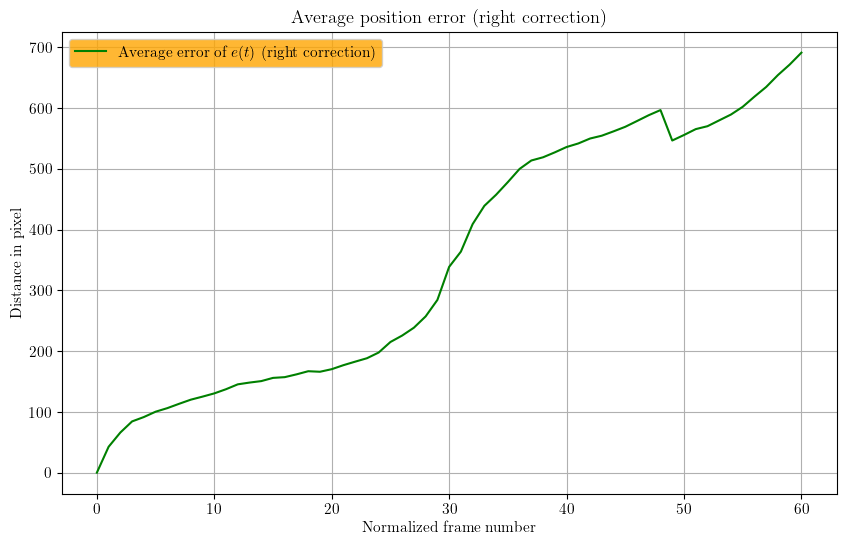

In [30]:

fig=plt.figure()
fig.set_size_inches(10,6) 
plt.grid()
ax = fig.gca()
ax.plot(t,np.linalg.norm(pos_from_estimation_avg-pos_from_rotation_right_avg,axis=1),color="green",label="Average error of $e(t)$ (right correction)")
plt.title('Average position error (right correction)')
plt.xlabel('Normalized frame number')
plt.ylabel('Distance in pixel')

# Add the legend with custom elements
plt.legend(frameon=True, facecolor="orange")
plt.show()
ax.set_rasterized(True)
fig.savefig('../export_graphs/right_avg_error_pos.eps', format="eps", dpi=1200, bbox_inches="tight")